In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# data source:https://www.kaggle.com/c/msk-redefining-cancer-treatment/data?select=stage1_solution_filtered.csv.7z

In [4]:
path='/Users/yingyuxuan/Downloads/msk-redefining-cancer-treatment/data/'

In [5]:
# load the text train data  and text data
train_text= pd.read_csv(path+'training_text', sep='\|\|', header=None, skiprows=1, names=["ID","Text"])

train_variants= pd.read_csv(path+'training_variants')


In [6]:
# check the shape of each dataset
train_text.shape

(3321, 2)

In [7]:
train_variants.shape

(3321, 4)

In [8]:
# before we remove those missing 
#text data we need to merge variants data and text data 
train = pd.merge(train_variants,train_text, how='left', on='ID')

In [9]:
train.isnull().sum() # there are five missing data in text column

ID           0
Gene         0
Variation    0
Class        0
Text         5
dtype: int64

In [10]:
# remove missing values
df_train=train.dropna(axis=0).copy()
df_train.shape

(3316, 5)

In [11]:
df_train.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


# EDA

- ID (the id of the row used to link the mutation to the clinical evidence), 
- Gene (the gene where this genetic mutation is located), 
- Variation (the aminoacid change for this mutations),
- Class (1-9 the class this genetic mutation has been classified on)

## Class

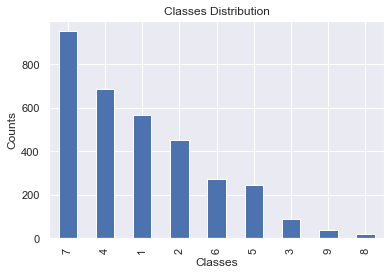

In [75]:
df_train.Class.value_counts().plot(kind="bar",title='Classes Distribution')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.show()

## Gene

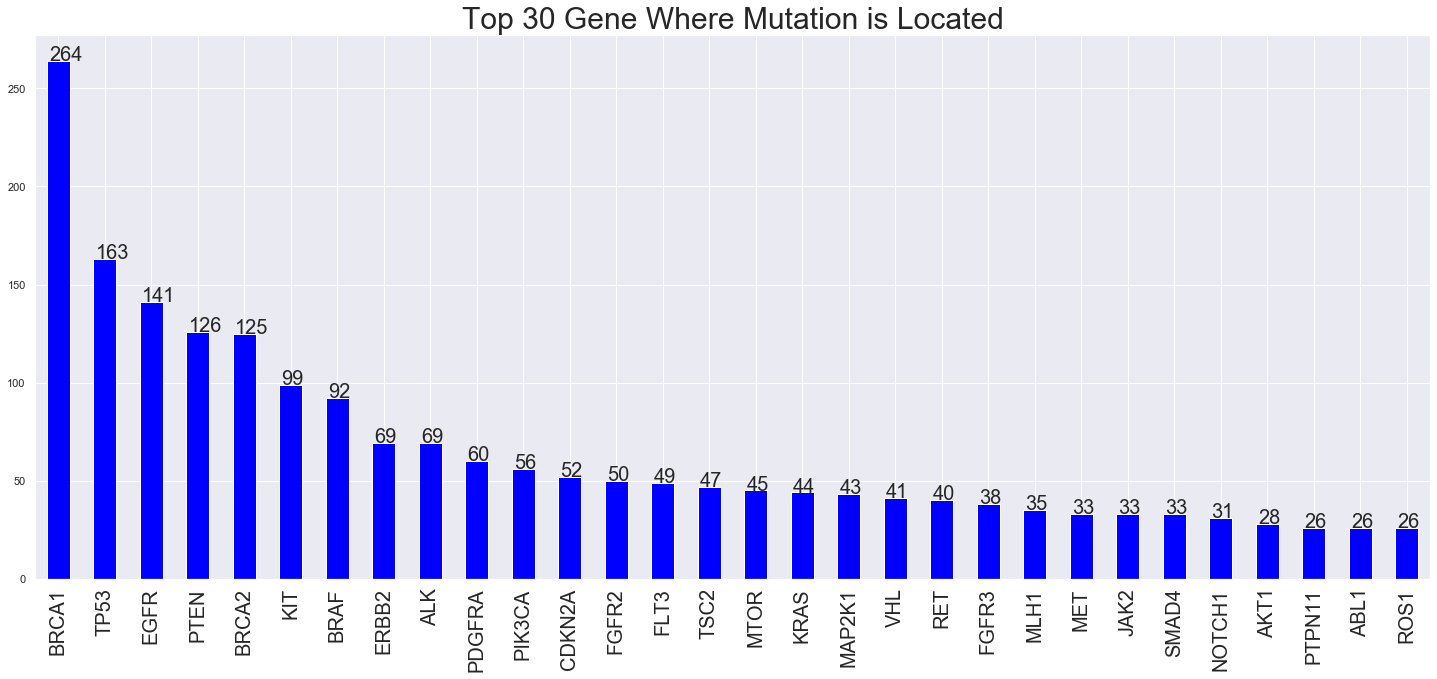

In [80]:
# Plot top 30 the frequency of the gene where this genetic mutation is located
df_train.Gene.value_counts()[:30].plot(kind='bar',figsize=(25,10),color='blue')
plt.xticks(fontsize=20)
plt.title("Top 30 Genes Where Mutation is Located",fontsize=30)
for i in range(0,30):
    plt.text(i-0.2,df_train.Gene.value_counts()[:30][i],"{}".format(df_train.Gene.value_counts()[:30][i]),fontsize=20)

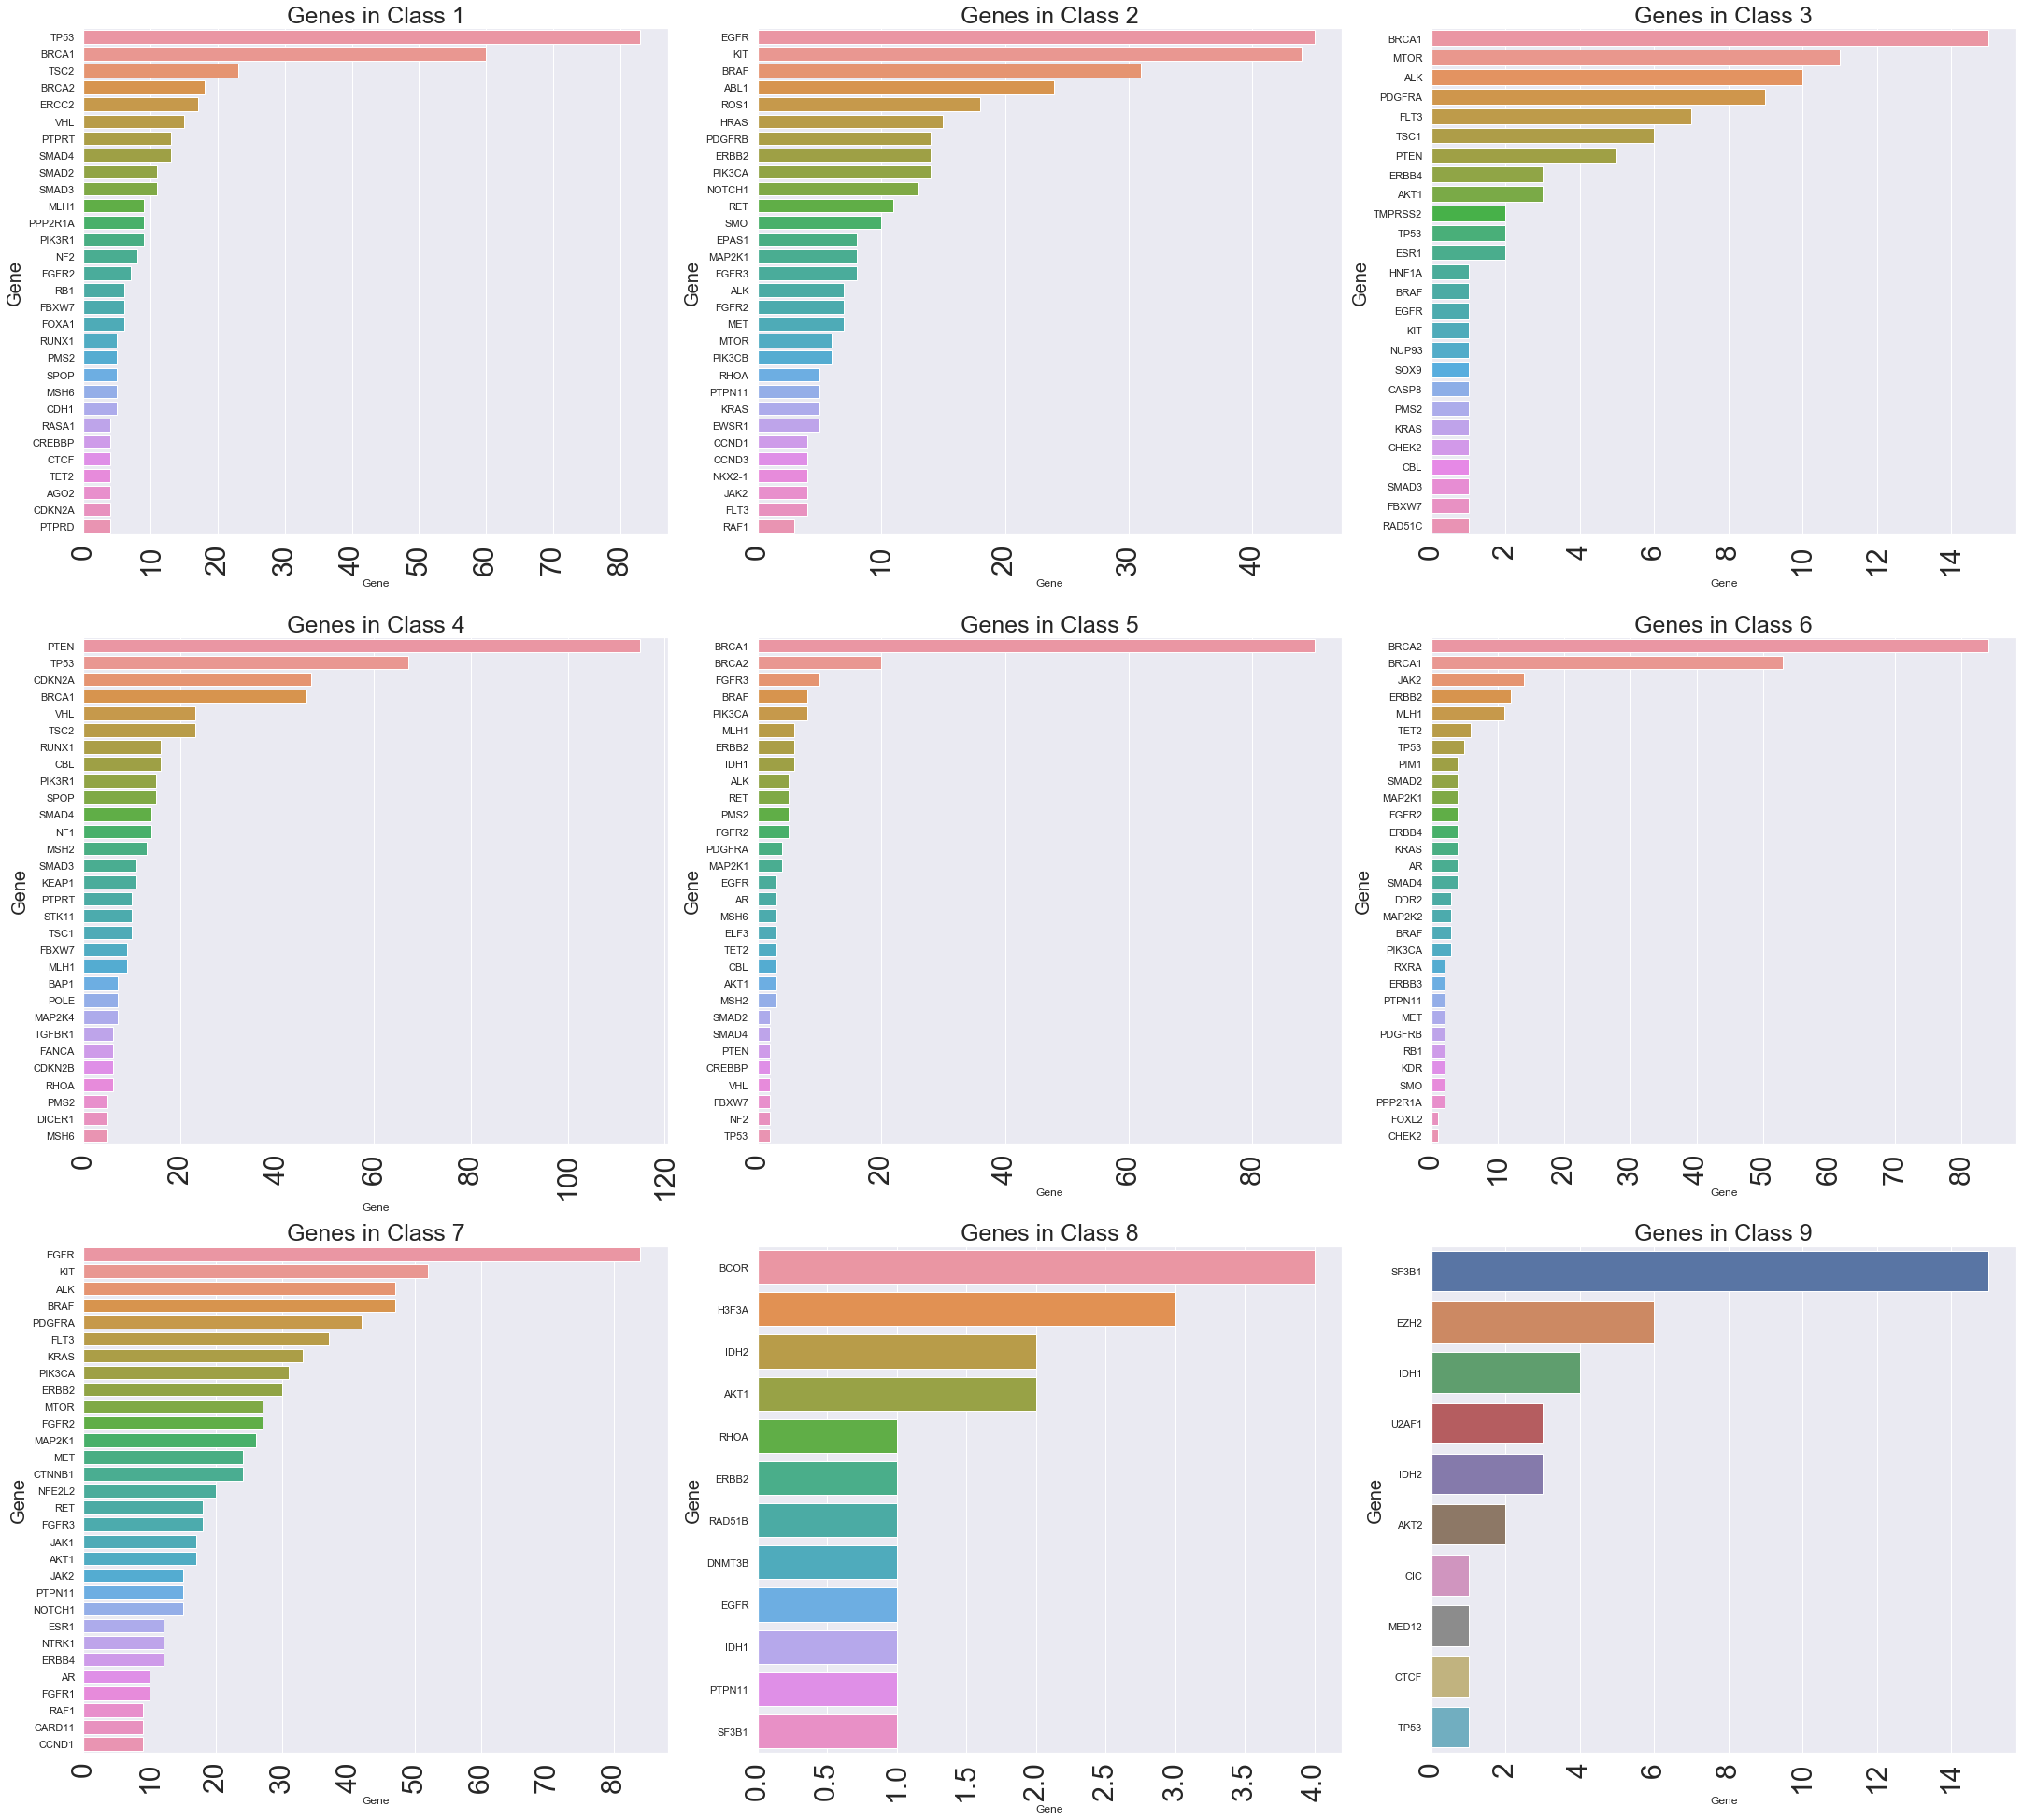

In [115]:
# Gene & Class
plt.figure(figsize=(30,27))
for i in range(0,9):
    class_df=pd.DataFrame(df_train[df_train.Class==i+1].Gene.value_counts()).reset_index()[:30]
    plt.subplot(3,3,i+1)
    sns.barplot(class_df['Gene'],class_df['index'])
    plt.xticks(rotation=90,size=30)
    plt.ylabel("Gene",fontsize=20)
    plt.title('Genes in Class {}'.format(list(set(df_train.Class))[i]),fontsize=25)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

## Variation

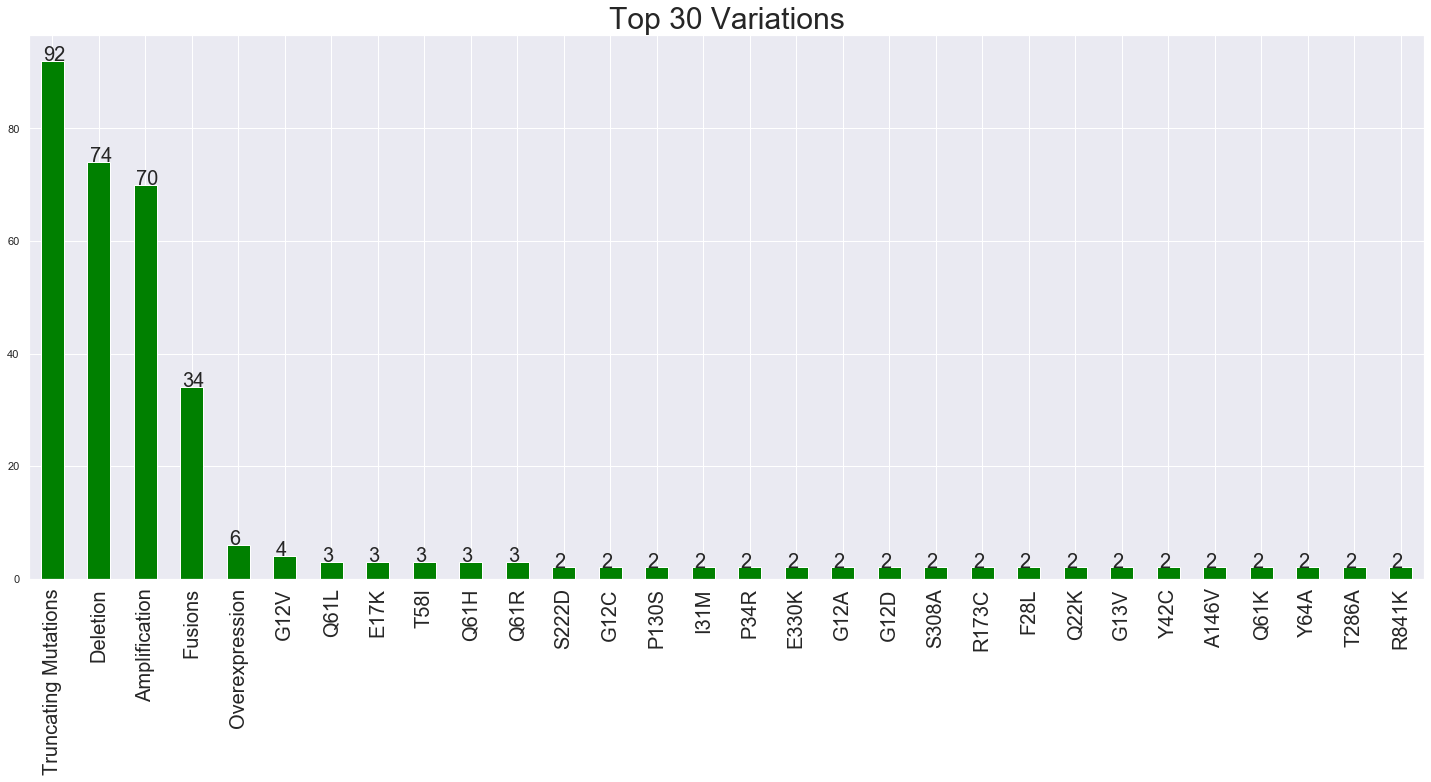

In [86]:
df_train.Variation.value_counts()[:30].plot(kind='bar',figsize=(25,10),color='green')
plt.xticks(fontsize=20)
plt.title("Top 30 Variations",fontsize=30)
for i in range(0,30):
    plt.text(i-0.2,df_train.Variation.value_counts()[:30][i],"{}".format(df_train.Variation.value_counts()[:30][i]),fontsize=20)

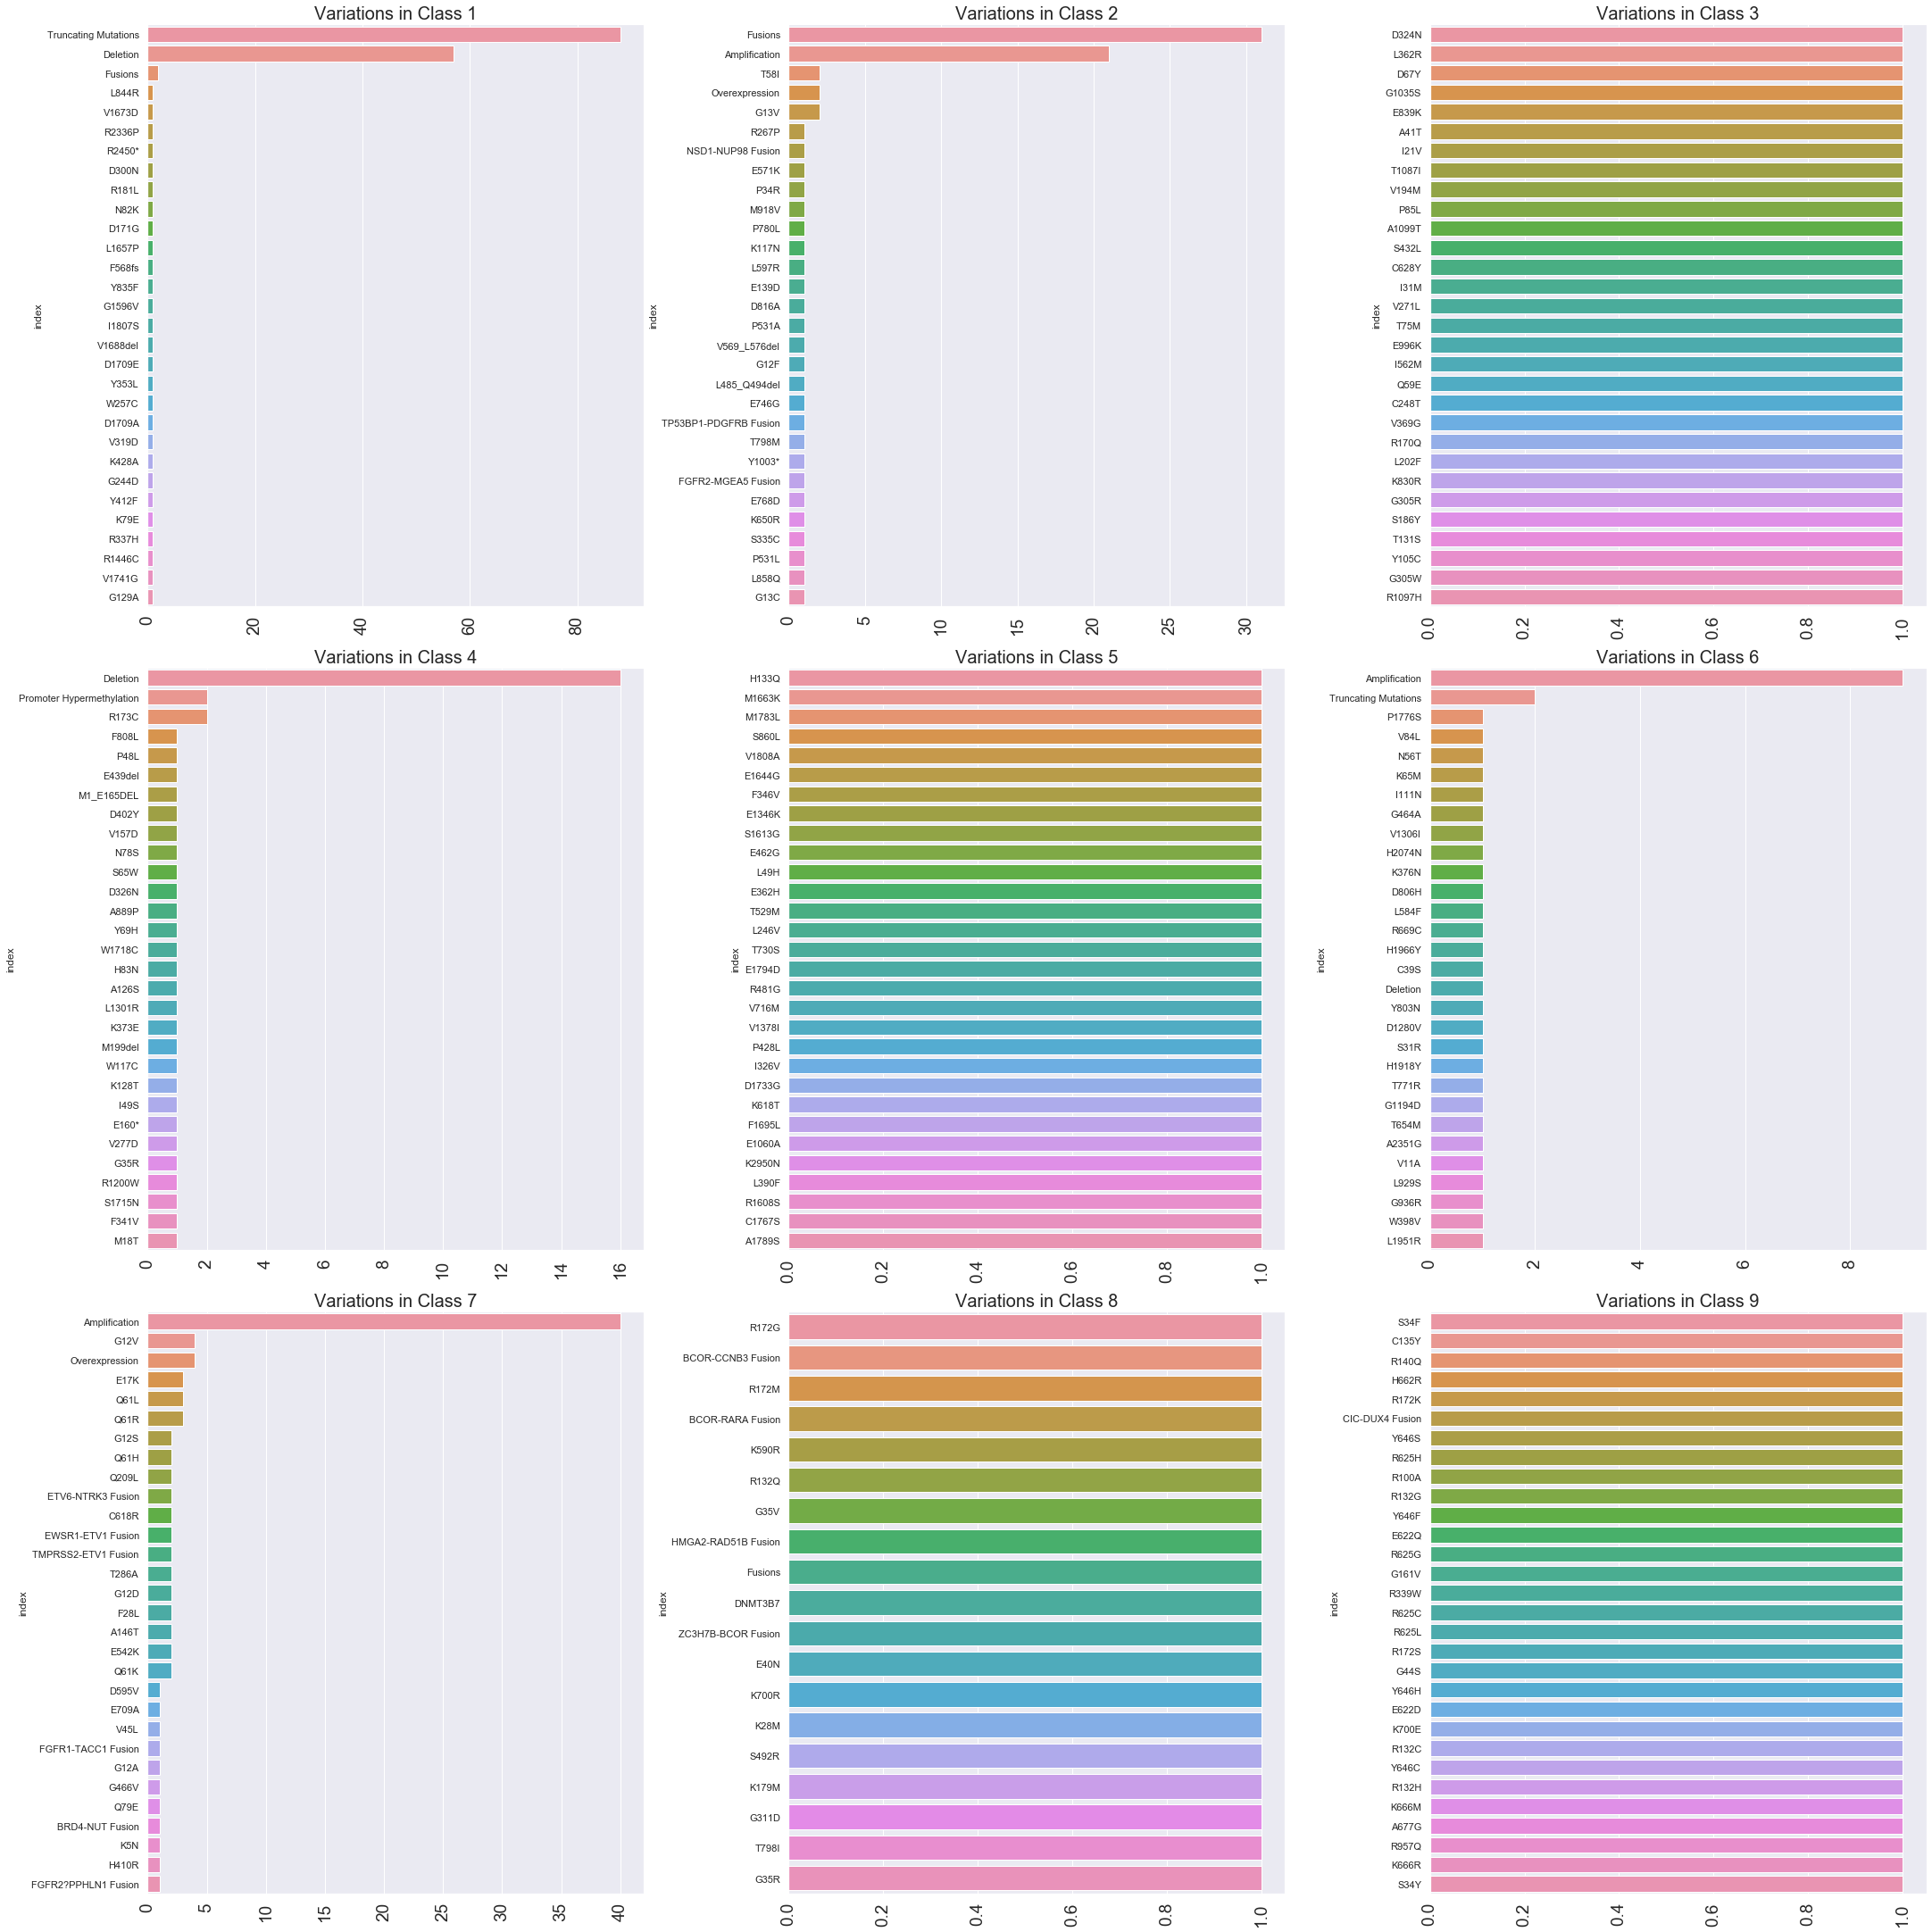

In [112]:
# Gene & Class
plt.figure(figsize=(30,30))
for i in range(0,9):
    class_df=pd.DataFrame(df_train[df_train.Class==i+1].Variation.value_counts()).reset_index()[:30]
    plt.subplot(3,3,i+1)
    sns.barplot(class_df['Variation'],class_df['index'])
    plt.xticks(rotation=90,size=19)
    plt.xlabel("")
    plt.title('Variations in Class {}'.format(list(set(df_train.Class))[i]),fontsize=20)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

## Data Engineering

In [198]:
import re, string
from nltk.corpus import stopwords
import nltk

In [187]:
# Create functions for tokenization, stemming, Lelemmatization and 
# finally combine all functions together to obtain cleaned_text_date for train and test data


sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘',"'", '©',
'said',"'s", "also",'one',"n't",'com', 'satirewire', '-', '–', "et al",
'—', '_','et al ',"/"]
sw_set = set(sw_list)

# tokenization
def process_review(review):
    tokens = nltk.word_tokenize(review) # tokenization
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in sw_set]# stop workds removal
    return stopwords_removed

# Stemming
from nltk.stem import PorterStemmer
ps = PorterStemmer()
# create a function stemming() and loop through each word in a review
def stemming(review):
    stemmed_review=[]
    for w in review:
        stemmed_review.append(ps.stem(w))
    return stemmed_review

# import libraries
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# create a function  and loop through each word in  a review
def lemmatization(review):
    lemma_list=[]
    for word in review:
        lemma_word=lemmatizer.lemmatize(word,pos='v') 
        lemma_list.append(lemma_word)
    return lemma_list

# Conbime all functions above and obtian cleaned text data 
def data_preprocessing(review):
    #tokenization, stop words removal, punctuation marks removel
    processed_review=list(map(process_review,review))
    # stemming
    stemming_reviews=list(map(stemming,processed_review))
    # lemmatization
    lemma_reviews=list(map(lemmatization,stemming_reviews))
    return lemma_reviews


In [192]:
cleaned_train_text=data_preprocessing(df_train['Text'])

In [157]:
import pickle
pickle_out1=open('cleaned_train_text', 'wb')
pickle.dump(cleaned_train_text, pickle_out1)
pickle_out1.close()
pickle_out2.close()

In [12]:
import pickle
pickle_in_train = open("cleaned_train_text","rb")
cleaned_train_text = pickle.load(pickle_in_train)

## N-grams


In [42]:
df_train['cleaned_text']=[" ".join(i) for i in cleaned_train_text]

In [122]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
#source:https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

In [124]:
# Apply the function above foe each class
class1 = get_top_n_bigram(df_train[df_train['Class']==1]['cleaned_text'], 30)
class2=  get_top_n_bigram(df_train[df_train['Class']==2]['cleaned_text'], 30)
class3 = get_top_n_bigram(df_train[df_train['Class']==3]['cleaned_text'], 30)
class4 = get_top_n_bigram(df_train[df_train['Class']==4]['cleaned_text'], 30)
class5 = get_top_n_bigram(df_train[df_train['Class']==5]['cleaned_text'], 30)
class6 = get_top_n_bigram(df_train[df_train['Class']==6]['cleaned_text'], 30)
class7 = get_top_n_bigram(df_train[df_train['Class']==7]['cleaned_text'], 30)
class8 = get_top_n_bigram(df_train[df_train['Class']==8]['cleaned_text'], 30)
class9 = get_top_n_bigram(df_train[df_train['Class']==9]['cleaned_text'], 30)

In [179]:
classes_data=[class1[1:],class2[1:],class3[1:],class4[1:],classfive,
              class6[1:],class7[1:],class8[1:],class9[1:]]
colors=['r','b','g','pink','c','m','y','aqua','plum']

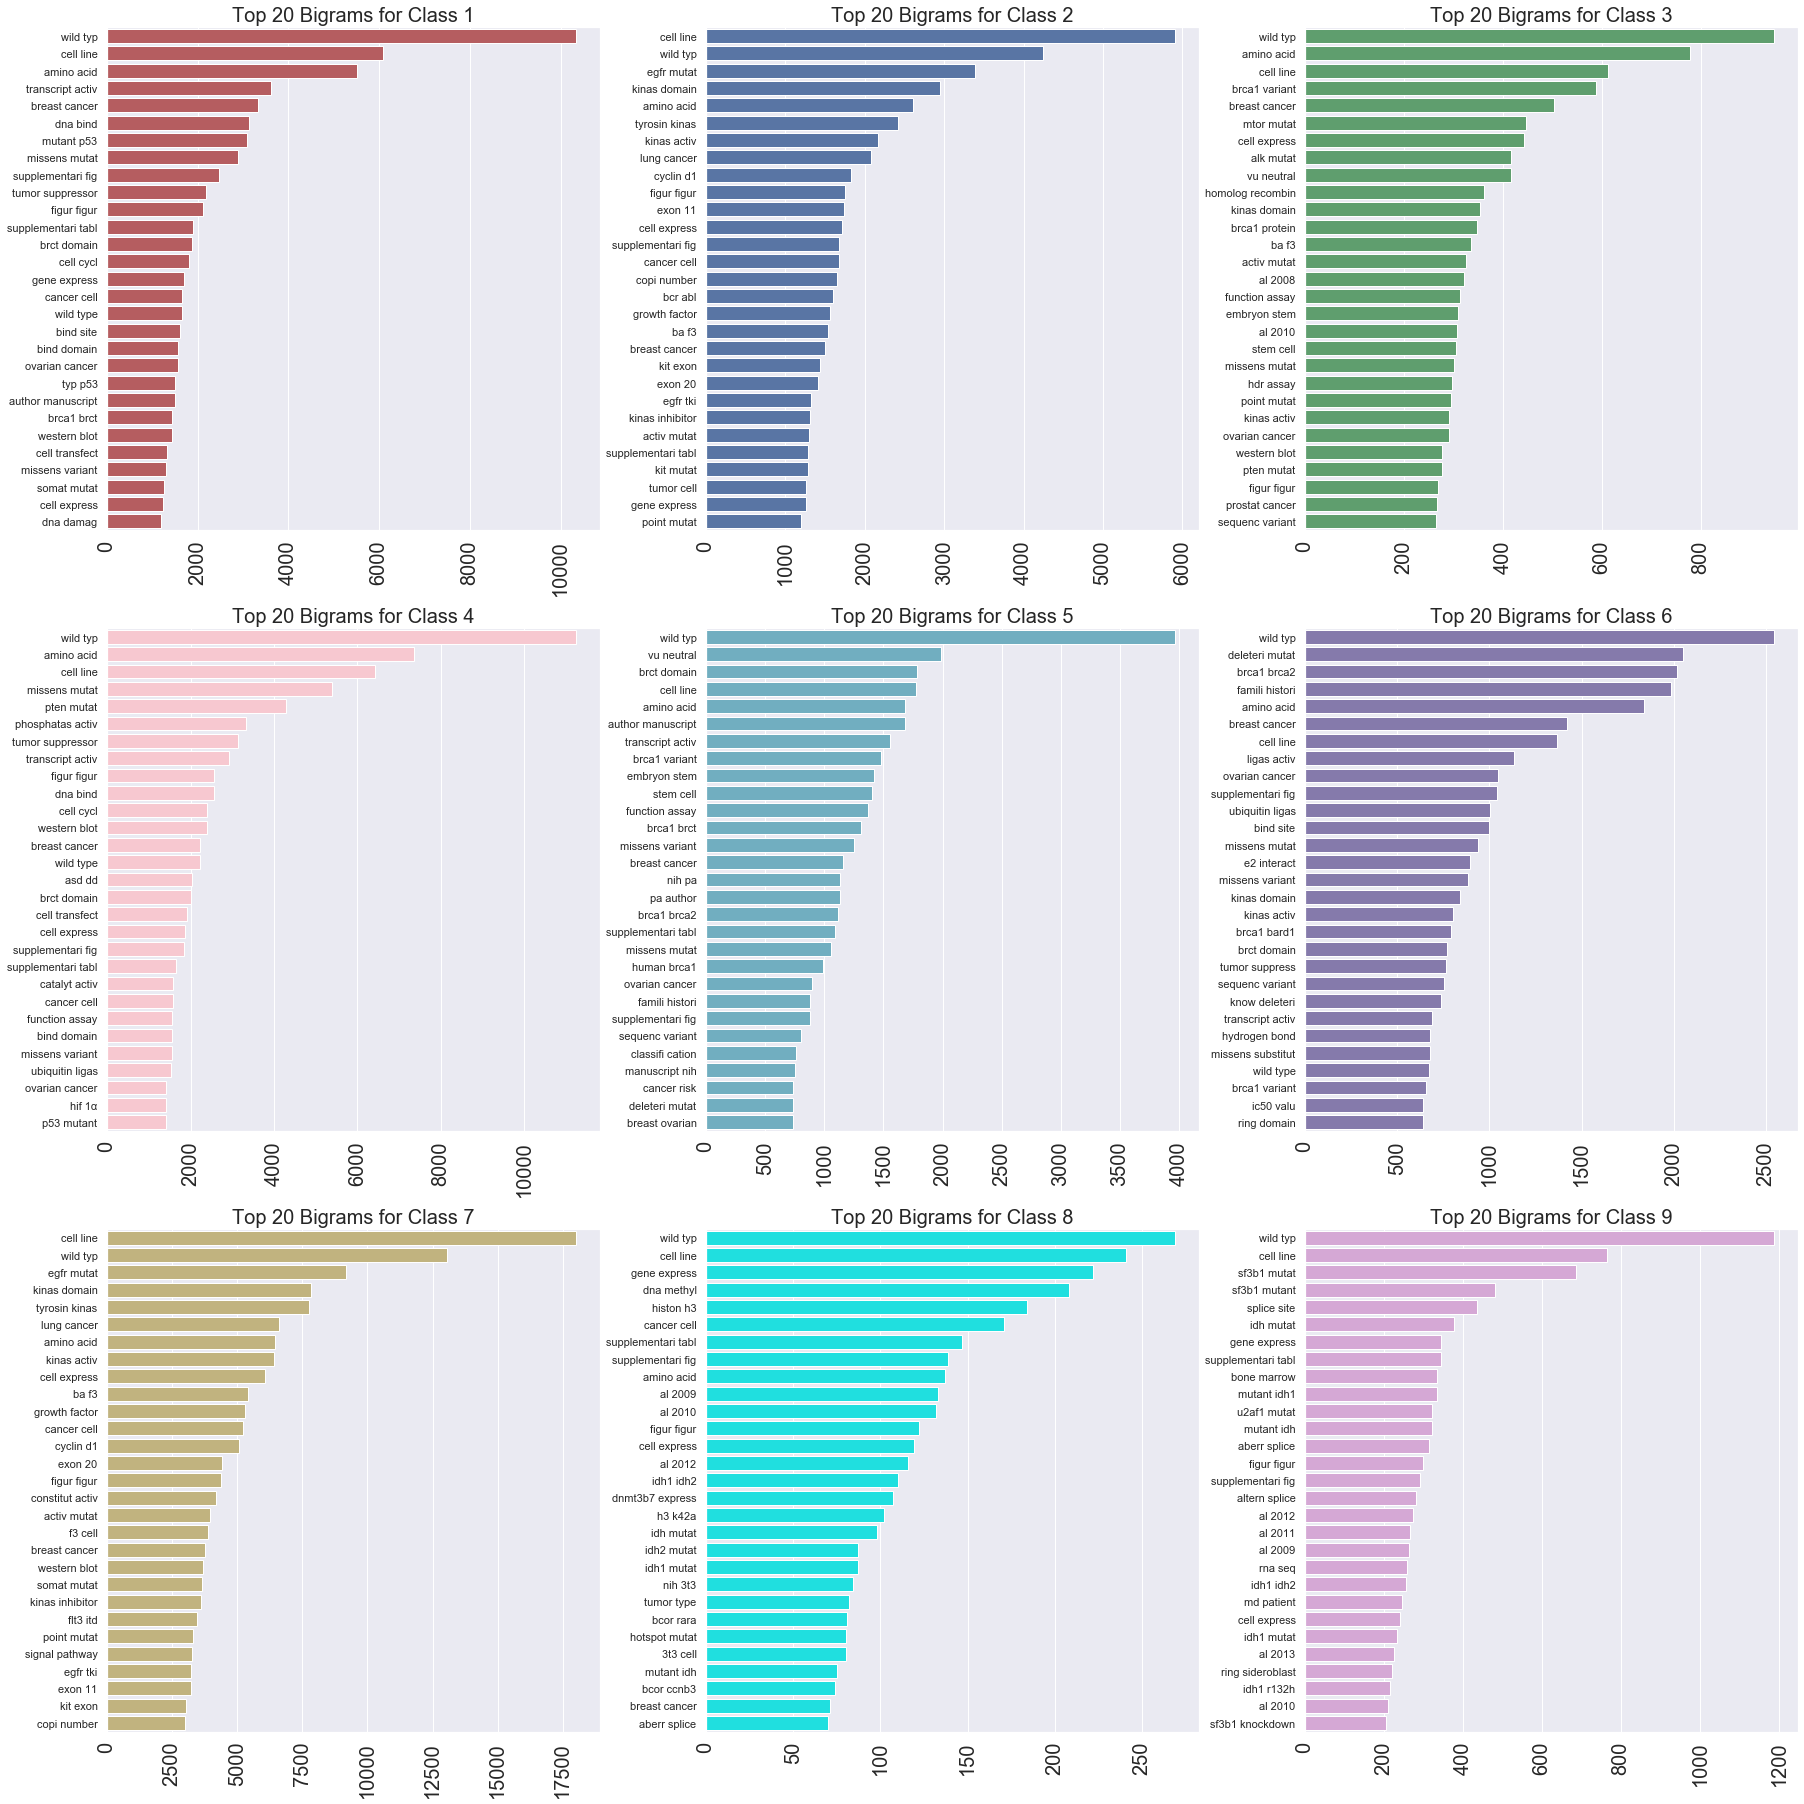

In [180]:
plt.figure(figsize=(25,25))
for i in range(0,9):
    plt.subplot(3,3,i+1)
    x=[x[0] for x in classes_data[i]]
    y=[x[1] for x in  classes_data[i]]
    sns.barplot(y,x,color=colors[i])
    plt.xticks(rotation=90,fontsize=20)
    plt.title("Top 20 Bigrams for Class {}".format(i+1),fontsize=20)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

In [202]:
# Trigrams
def get_top_n_ngram(corpus, n=None,k=None):
    vec = CountVectorizer(ngram_range=(k,k )).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
#source:https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

In [203]:
# Apply the function above foe each class
class1t = get_top_n_ngram(df_train[df_train['Class']==1]['cleaned_text'], 30,5)
class2t = get_top_n_ngram(df_train[df_train['Class']==2]['cleaned_text'], 30,5)
class3t = get_top_n_ngram(df_train[df_train['Class']==3]['cleaned_text'], 30,5)
class4t = get_top_n_ngram(df_train[df_train['Class']==4]['cleaned_text'], 30,5)
class5t = get_top_n_ngram(df_train[df_train['Class']==5]['cleaned_text'], 30,5)
class6t = get_top_n_ngram(df_train[df_train['Class']==6]['cleaned_text'], 30,5)
class7t = get_top_n_ngram(df_train[df_train['Class']==7]['cleaned_text'], 30,5)
class8t = get_top_n_ngram(df_train[df_train['Class']==8]['cleaned_text'], 30,5)
class9t = get_top_n_ngram(df_train[df_train['Class']==9]['cleaned_text'], 30,5)

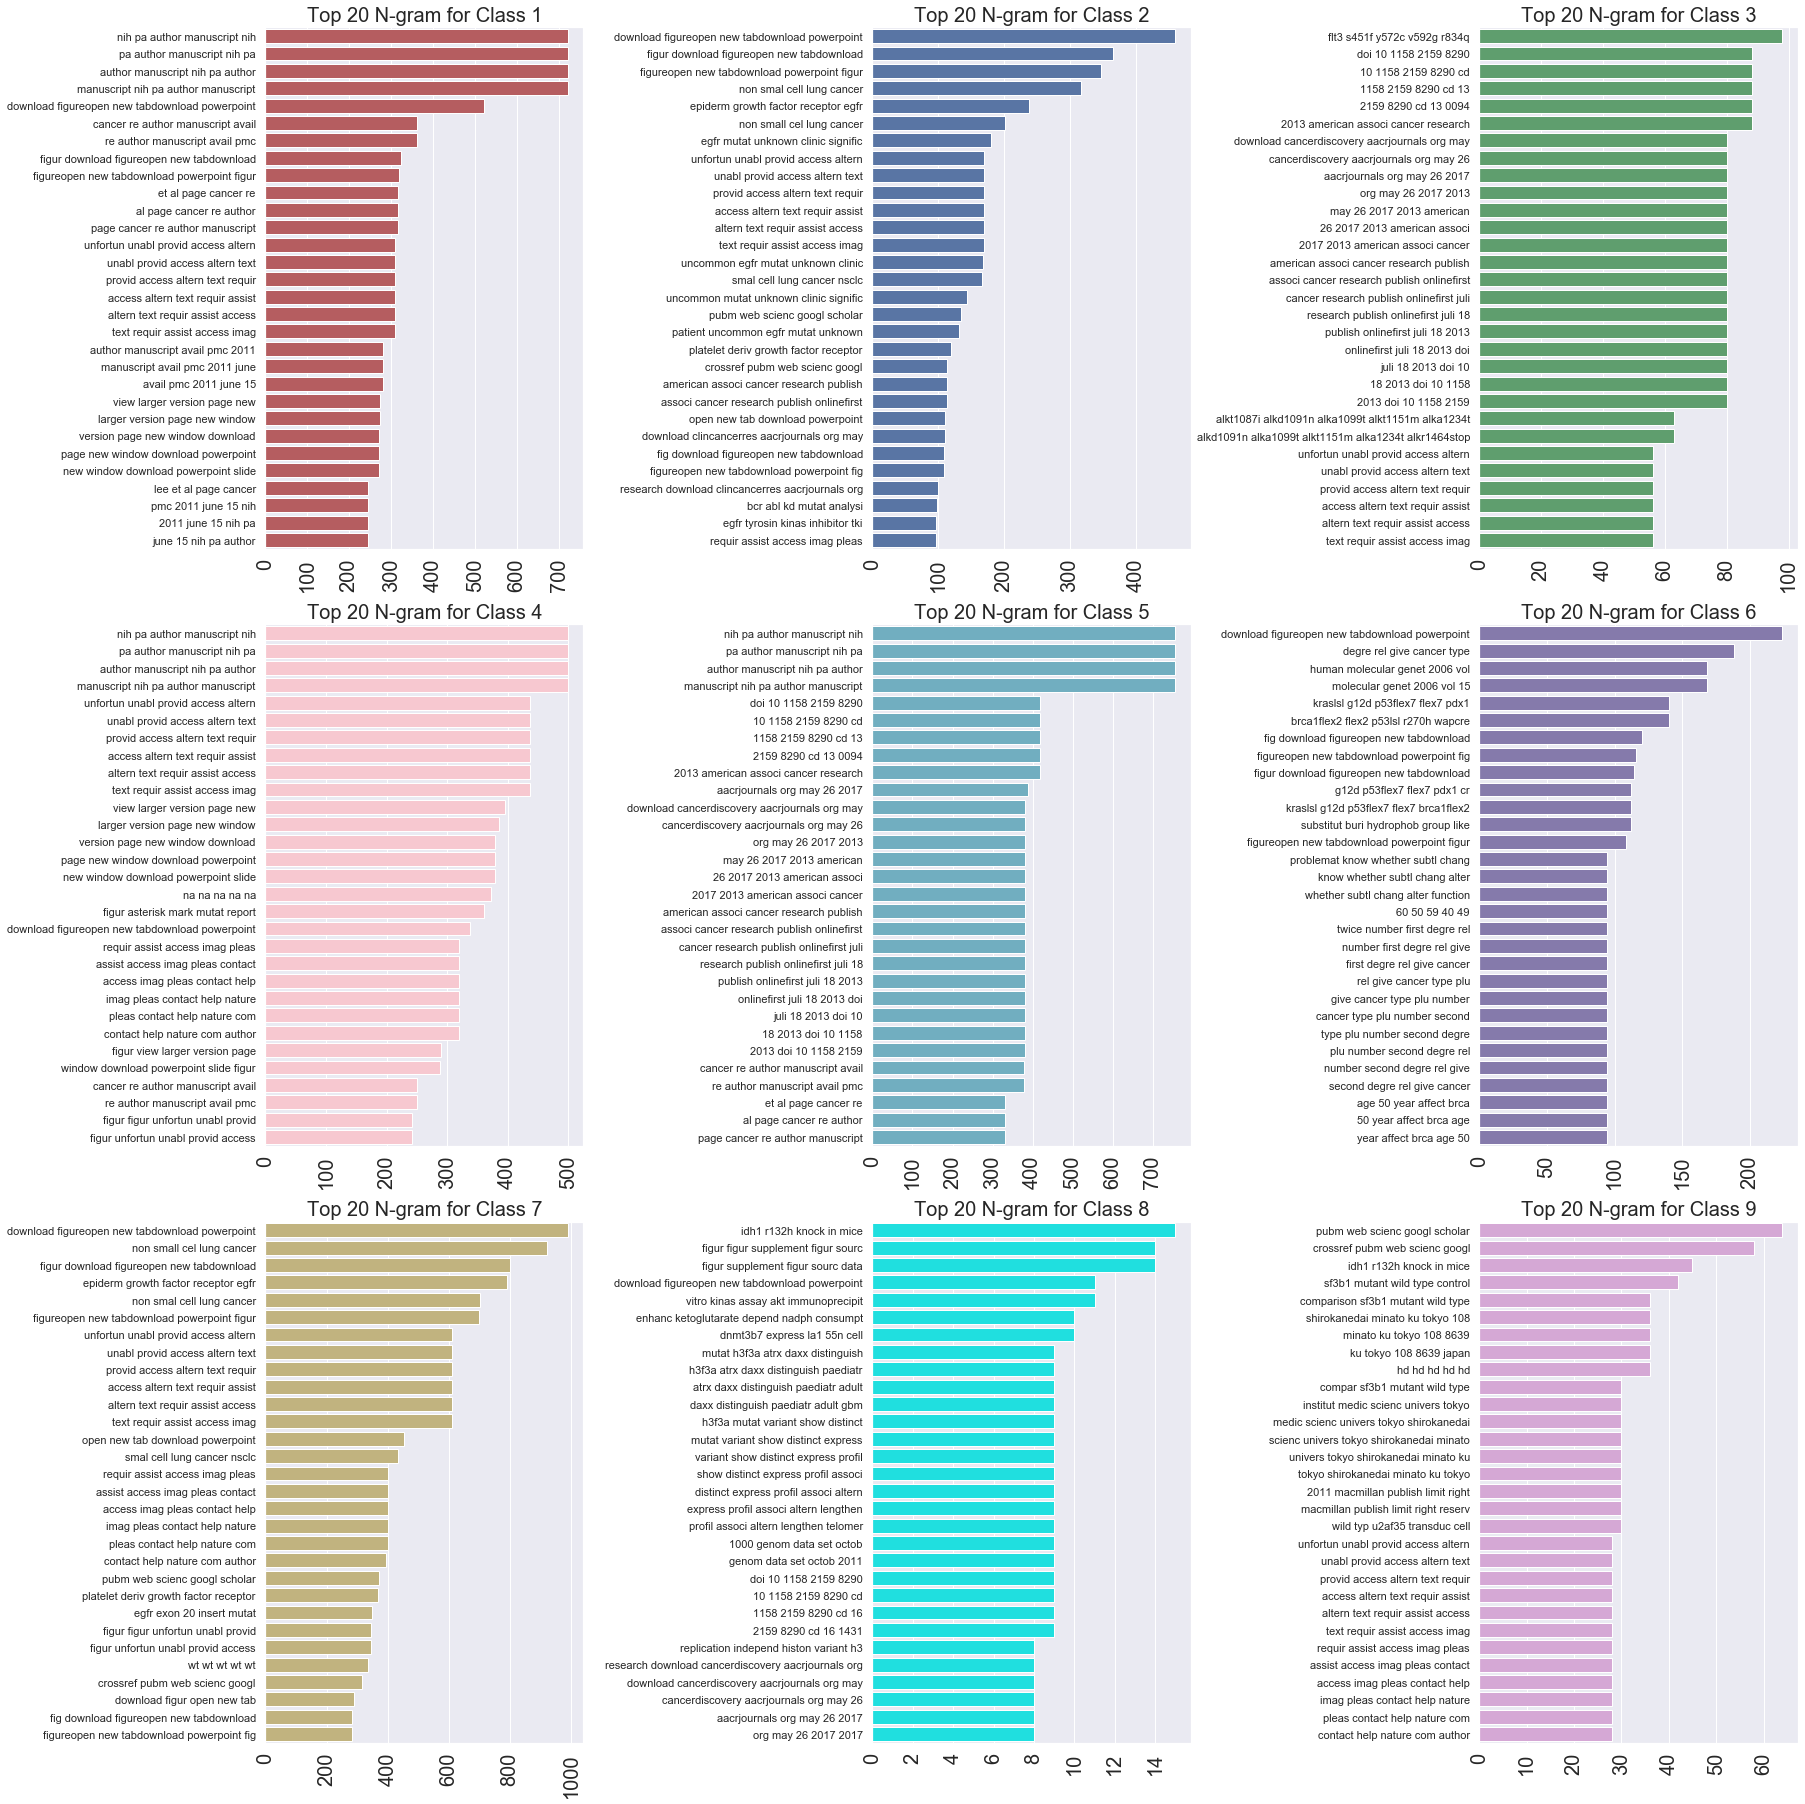

In [205]:
classest_data=[class1t,class2t,class3t,class4t,class5t,
              class6t,class7t,class8t,class9t]
plt.figure(figsize=(25,25))
# good reviews bigrams
for i in range(0,9):
    plt.subplot(3,3,i+1)
    x=[x[0] for x in classest_data[i]]
    y=[x[1] for x in  classest_data[i]]
    sns.barplot(y,x,color=colors[i])
    plt.xticks(rotation=90,fontsize=20)
    plt.title("Top 20 N-gram for Class {}".format(i+1),fontsize=20)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

In [43]:
#declare inputs and target
inputs=df_train[['ID', 'Gene', 'Variation','cleaned_text']]
target=df_train.Class

# Resampling 

In [44]:
from sklearn.utils import resample

In [45]:
training  = pd.DataFrame()
training[list(inputs.columns)]=inputs
training['target']=target
training.head()

,ID,Gene,Variation,cleaned_text,target
0,0,FAM58A,Truncating Mutations,cyclin-depend kinas cdk regul varieti fundamen...,1
1,1,CBL,W802*,abstract background non-smal cell lung cancer ...,2
2,2,CBL,Q249E,abstract background non-smal cell lung cancer ...,2
3,3,CBL,N454D,recent evid demonstr acquir uniparent disomi a...,3
4,4,CBL,L399V,oncogen mutat monomer casita b-lineag lymphoma...,4


In [46]:
# separate minority and majority classes
classes_list=[]
for i in range(0,9):
    class_i= training[training.target==i+1]
    classes_list.append(class_i)
    print("Class {}: ".format(i+1)+str(len(class_i)))
# we can see class 7 is the majority class and  class 3,8,9 contain very small size of samples 

Class 1: 566
Class 2: 452
Class 3: 89
Class 4: 686
Class 5: 242
Class 6: 273
Class 7: 952
Class 8: 19
Class 9: 37


In [47]:
# upsample minority
def oversampling(majority,minority):
    minority_upsampled = resample(minority,
                              replace=True, # sample with replacement
                              n_samples=len(majority), # match number in majority class
                              random_state=365) # reproducible results
    return minority_upsampled

In [48]:
# since class 7 is our majority group we need to remove it from our classes list 
classes_list.pop(-3)# remove class 7 dataset

,ID,Gene,Variation,cleaned_text,target
28,28,TERT,C228T,sequenc studi identifi mani recurr code mutat ...,7
31,31,TERT,Promoter Mutations,sequenc studi identifi mani recurr code mutat ...,7
34,34,TERT,C250T,sequenc studi identifi mani recurr code mutat ...,7
67,67,RHEB,Y35C,gene encod compon pi3k-akt-mtor signal axi fre...,7
68,68,RHEB,Y35N,gene encod compon pi3k-akt-mtor signal axi fre...,7
...,...,...,...,...,...
3292,3292,RET,C634Y,investigatedth transformingactivityofth ret pr...,7
3294,3294,RET,R886W,introduct inherit germ line activ mutat rearra...,7
3296,3296,RET,Y791F,ret proto-oncogen encod receptor tyrosin kinas...,7
3308,3308,RUNX1,R174*,famili platelet disord propens acut myeloid le...,7


In [49]:
len(classes_list)# now wen have 8 different classes

8

In [50]:
# now using the function above loop through all classes datasets
upsampled_classes_list=[]
for cla in classes_list:
    upsample_df=oversampling(training[training.target==7],cla)
    upsampled_classes_list.append(upsample_df)

In [51]:
# and we also include class 7 data
class_7df=training[training.target==7]
upsampled_classes_list.append(class_7df)

In [52]:
# combine majority and upsampled minority
upsampled=pd.concat(upsampled_classes_list)
# check new class counts
upsampled.target.value_counts(),len(upsampled_classes_list)

(7    952
 6    952
 5    952
 4    952
 3    952
 2    952
 9    952
 1    952
 8    952
 Name: target, dtype: int64,
 9)

In [53]:
# declare target and inputs
target = upsampled.target
inputs= upsampled.drop(columns=['ID','target'], axis=1)

In [54]:
# target.to_csv("target.csv")
# inputs.to_csv("inputs.csv")

In [56]:
inputs.columns# check the columns

Index(['Gene', 'Variation', 'cleaned_text'], dtype='object')

In [57]:
#train test split dataset
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(inputs, target, test_size=.2, random_state=0)


# Vectorizing Text Data

In [58]:
from sklearn.feature_extraction.text import CountVectorizer

In [59]:
def vectorizer(train,test):
    vectorizer=CountVectorizer()
    new_train=vectorizer.fit_transform(train)
    new_test=vectorizer.transform(test)
    return new_train,new_test

In [60]:
# Vectorize each column for x_train and x_test 
gene_train,gene_test=vectorizer(x_train.Gene,x_test.Gene)
variation_train,variation_test=vectorizer(x_train.Variation,x_test.Variation)
cleaned_text_train,cleaned_text_test=vectorizer(x_train.cleaned_text,x_test.cleaned_text)

# Naive Bayes 


In [74]:
# Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score,make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
f1 = make_scorer(f1_score , average='weighted')

def NB_GridSearch(X_train, y_train):
    grid_params = {'alpha':[0.1,0.2,0.3,0.4,0.5],
                     'fit_prior': [True, False],  }
    
    gs = GridSearchCV( MultinomialNB(), grid_params,scoring=f1, cv=10)
    gs.fit(X_train, y_train)
    print("Best Score: ", gs.best_score_)
    print("Best Alpha: ", gs.best_params_)

    return gs.best_params_.values()

In [78]:
def NaiveBayes(X_train,y_train,X_test,y_test,alpha,fit_prior):    
    # fit the training dataset on the NB classifier
    Naive = MultinomialNB(alpha=0.1, fit_prior= True)
    Naive.fit(X_train,y_train)
    #prediction
    nb_train_pre=Naive.predict(X_train)
    nb_test_pre=Naive.predict(X_test)
    # Use accuracy_score function to get the accuracy
    print("Naive Bayes Train Accuracy Score :",accuracy_score(nb_train_pre, y_train))
    print("Naive Bayes Test Accuracy Score :",accuracy_score(nb_test_pre, y_test))
    # calculate f1 scores for test data and train data 
    nb_f1_score_test=f1_score(y_test,nb_test_pre,average='weighted')
    nb_f1_score_train=f1_score(y_train,nb_train_pre,average='weighted')
    print("Train data f1 score:{}".format(nb_f1_score_train))
    print("Test data f1 score:{}".format(nb_f1_score_test ))
    print("confusion_matrix:{}".format(confusion_matrix(y_test, nb_test_pre)))
    print('==================================================================')
    return nb_train_pre,nb_test_pre

In [79]:
# to get best score and best alpha
alpha1,fit_prior1=NB_GridSearch(gene_train, y_train)
alpha2,fit_prior2=NB_GridSearch(variation_train, y_train)
alpha3,fit_prior3=NB_GridSearch(cleaned_text_train, y_train)

Best Score:  0.5970584437980415
Best Alpha:  {'alpha': 0.1, 'fit_prior': True}
Best Score:  0.7728241967182794
Best Alpha:  {'alpha': 0.1, 'fit_prior': True}
Best Score:  0.7511472104042424
Best Alpha:  {'alpha': 0.1, 'fit_prior': True}


In [80]:
# results
nb_train_pre1,nb_test_pre1=NaiveBayes(gene_train,y_train,gene_test,y_test,alpha1,fit_prior1)
nb_train_pre2,nb_test_pre2=NaiveBayes(variation_train,y_train,variation_test,y_test,alpha1,fit_prior1)
nb_train_pre3,nb_test_pre3=NaiveBayes(cleaned_text_train,y_train,cleaned_text_test,y_test,alpha1,fit_prior1)

Naive Bayes Train Accuracy Score : 0.6216807703530784
Naive Bayes Test Accuracy Score : 0.6003500583430572
Train data f1 score:0.6157672054520656
Test data f1 score:0.5930716695679839
confusion_matrix:[[ 93   2   7  28  36  12   8   2   4]
 [  3 115   5   1   8   7  27   9   2]
 [  7  10 118  13  31   0   1   9   0]
 [ 44   4   6 118  22   7   0   2   0]
 [ 12  12   3  11 101  17   7   6   4]
 [ 11   7   4   1  46  99  10  15   0]
 [  2  59  38   0  16   8  40  15   4]
 [  0  10   0   0   0   0   0 166  21]
 [  7   0   0   0   0   0   0  22 179]]
Naive Bayes Train Accuracy Score : 0.9772395681353954
Naive Bayes Test Accuracy Score : 0.8191365227537923
Train data f1 score:0.9774319139048305
Test data f1 score:0.8126132108732343
confusion_matrix:[[156   0   0   2  34   0   0   0   0]
 [  0 157   0   0  16   0   4   0   0]
 [  0   0 189   0   0   0   0   0   0]
 [  4   0   0 141  58   0   0   0   0]
 [  0   0   2   0 171   0   0   0   0]
 [  0   8   0   0  16 169   0   0   0]
 [  1  18   

# Neural Network

In [65]:
# thanks to :https://realpython.com/python-keras-text-classification/
import keras
# from keras.models import Sequential
# from keras.layers import Dense, Dropout
# from keras.optimizers import RMSprop
from keras.optimizers import Adam, SGD
from keras.utils import to_categorical

In [70]:
def history_model(X_train, y_train,X_test, y_test):

    #Before we build our model, we need to know the input dimension of our feature vectors.
    input_dim = X_train.shape[1] 
    # Add layers one by one in order 
    model = Sequential()
    model.add(keras.layers.Dense(60, input_dim=input_dim, activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.Dense(10, activation='softmax'))
    opt = SGD(lr=0.01, momentum=0.9)
    #specify the optimizer and the loss function.
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    #Give an overview of the model and the number of parameters available for training:
    model.summary()
    # # fit the model
    history = model.fit(X_train, y_train,epochs=50, verbose=2,
                    validation_data=(X_test, y_test),batch_size=70)
    return history, model

In [67]:
Y_train=to_categorical(y_train)
Y_test=to_categorical(y_test)

In [71]:
history1, model1=history_model(gene_train, Y_train,gene_test, Y_test)
history2, model2=history_model(variation_train, Y_train,variation_test, Y_test)
history3, model3=history_model(cleaned_text_train, Y_train,cleaned_text_test, Y_test)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 60)                14520     
_________________________________________________________________
dense_12 (Dense)             (None, 10)                610       
Total params: 15,130
Trainable params: 15,130
Non-trainable params: 0
_________________________________________________________________
Train on 6854 samples, validate on 1714 samples
Epoch 1/50
 - 1s - loss: 2.2053 - accuracy: 0.2733 - val_loss: 2.0776 - val_accuracy: 0.4825
Epoch 2/50
 - 1s - loss: 1.8962 - accuracy: 0.5474 - val_loss: 1.6911 - val_accuracy: 0.5741
Epoch 3/50
 - 1s - loss: 1.4966 - accuracy: 0.5940 - val_loss: 1.3390 - val_accuracy: 0.5998
Epoch 4/50
 - 1s - loss: 1.2364 - accuracy: 0.6112 - val_loss: 1.1728 - val_accuracy: 0.5992
Epoch 5/50
 - 1s - loss: 1.1157 - accuracy: 0.6157 - val_loss: 1.0968 - val_accuracy: 0.5986

 - 1s - loss: 0.0539 - accuracy: 0.9774 - val_loss: 0.3048 - val_accuracy: 0.8961
Epoch 25/50
 - 1s - loss: 0.0534 - accuracy: 0.9769 - val_loss: 0.3041 - val_accuracy: 0.8973
Epoch 26/50
 - 1s - loss: 0.0535 - accuracy: 0.9769 - val_loss: 0.3032 - val_accuracy: 0.8973
Epoch 27/50
 - 1s - loss: 0.0529 - accuracy: 0.9765 - val_loss: 0.3025 - val_accuracy: 0.8973
Epoch 28/50
 - 1s - loss: 0.0526 - accuracy: 0.9759 - val_loss: 0.3079 - val_accuracy: 0.8961
Epoch 29/50
 - 1s - loss: 0.0523 - accuracy: 0.9752 - val_loss: 0.3037 - val_accuracy: 0.8961
Epoch 30/50
 - 1s - loss: 0.0519 - accuracy: 0.9755 - val_loss: 0.3026 - val_accuracy: 0.8996
Epoch 31/50
 - 1s - loss: 0.0520 - accuracy: 0.9758 - val_loss: 0.3043 - val_accuracy: 0.8973
Epoch 32/50
 - 1s - loss: 0.0517 - accuracy: 0.9767 - val_loss: 0.3073 - val_accuracy: 0.8950
Epoch 33/50
 - 1s - loss: 0.0514 - accuracy: 0.9748 - val_loss: 0.3088 - val_accuracy: 0.8973
Epoch 34/50
 - 1s - loss: 0.0512 - accuracy: 0.9769 - val_loss: 0.2999 -

In [75]:
def NN_results(history,model,x_train,x_test):
    #prediction
    nn_train_pre=model.predict_classes(x_train)
    nn_test_pre=model.predict_classes(x_test)
    #calculate f1 scores for test data and train data 
    nn_f1_score_test=f1_score([int(i) for i in y_test],nn_test_pre,average='weighted')
    nn_f1_score_train=f1_score(y_train,nn_train_pre,average='weighted')
    print("Train data f1 score:{}".format(nn_f1_score_train))
    print("Test data f1 score:{}".format(nn_f1_score_test ))
    print(confusion_matrix(y_test, nn_test_pre))
    print('=================================================================')
    return nn_train_pre,nn_test_pre

In [76]:
# apply funtion above to obtian the results 
nn_train_pre1,nn_test_pre1=NN_results(history1,model1,gene_train,gene_test)
nn_train_pre2,nn_test_pre2=NN_results(history2,model2,variation_train,variation_test)
nn_train_pre3,nn_test_pre3=NN_results(history3,model3,cleaned_text_train,cleaned_text_test)

Train data f1 score:0.6143893769581936
Test data f1 score:0.5884727438700839
[[ 82   7   7  39  30  13   8   2   4]
 [  4 115   5   1   7   7  27   9   2]
 [  7  10 118  13  31   0   1   9   0]
 [ 34   7   6 128  19   7   0   2   0]
 [ 11  12   3  13  97  20   7   6   4]
 [  6   7   4   6  46  99  10  15   0]
 [  2  62  38   0  13   8  40  15   4]
 [  0  10   0   0   0   0   0 166  21]
 [  7   0   0   0   0   0   0  22 179]]
Train data f1 score:0.9780175131194836
Test data f1 score:0.9038712574030837
[[156   0   0   2   0   0  34   0   0]
 [  0 157   0   0   1   0  19   0   0]
 [  0   0 189   0   0   0   0   0   0]
 [  4   0   0 141   1   0  57   0   0]
 [  0   0   2   0 160   0  11   0   0]
 [  0   8   0   0   0 169  16   0   0]
 [  0  15   0   0   0   0 167   0   0]
 [  0   6   0   0   0   0   0 191   0]
 [  0   0   0   0   0   0   0   0 208]]
Train data f1 score:0.9008979145717564
Test data f1 score:0.8606824067325949
[[149   2   4   9  18  10   0   0   0]
 [  1 163   0   0   5   0 

# Logistic regression

In [87]:
#import Logistic Regression
from sklearn.linear_model import LogisticRegression

def Logistic_Regression(X_train, y_train,X_test, y_test):
    log_re = LogisticRegression(max_iter=1000)
    log_re.fit(X_train, y_train)
    #calculate scores for test data and train data 
    test_data_score = log_re.score(X_test, y_test)
    train_data_score = log_re.score(X_train, y_train)
    print("Train data score:{}".format(train_data_score ))
    print("Test data score:{}".format(test_data_score ))
    # predict values for test data and train data
    log_y_test_pre=log_re.predict(X_test)
    log_y_train_pre=log_re.predict(X_train)
    # calculate f1 scores for test data and train data 
    log_f1_score_test=f1_score(y_test,log_y_test_pre,average="weighted")
    log_f1_score_train=f1_score(y_train,log_y_train_pre,average="weighted")

    print("Train data f1 score:{}".format(log_f1_score_train))
    print("Test data f1 score:{}".format(log_f1_score_test ))
    print('=================================================================')
    return log_y_train_pre,log_y_test_pre

In [88]:
log_y_train_pre1,log_y_test_pre1=Logistic_Regression(gene_train, y_train,gene_test, y_test)
log_y_train_pre2,log_y_test_pr2=Logistic_Regression(variation_train, y_train,variation_test, y_test)
log_y_train_pre3,log_y_test_pre3=Logistic_Regression(cleaned_text_train, y_train,cleaned_text_test, y_test)

Train data score:0.621388969944558
Test data score:0.603267211201867
Train data f1 score:0.615936855192663
Test data f1 score:0.5957018668273237
Train data score:0.9768018675226146
Test data score:0.8961493582263711
Train data f1 score:0.9769987251836152
Test data f1 score:0.9029228363338574
Train data score:0.9034140647796907
Test data score:0.8640606767794633
Train data f1 score:0.9039234128069726
Test data f1 score:0.8628257154404384


# Model Stacking 

In [89]:
X_train = pd.DataFrame( {
    'nb_gene':nb_train_pre1,
    'nb_variation':nb_train_pre2,
    'nb_text':nb_train_pre3,
    'nn_gene':nn_train_pre1,
    'nn_variation':nn_train_pre2,
    'nn_text':nn_train_pre3,
    'log_gene':log_y_train_pre1,
    'log_variation':log_y_train_pre2,
    'log_text':log_y_train_pre3
   })

X_test = pd.DataFrame( {
    'nb_gene':nb_test_pre1,
    'nb_variation':nb_test_pre2,
    'nb_text':nb_test_pre3,
    'nn_gene':nn_test_pre1,
    'nn_variation':nn_test_pre2,
    'nn_text':nn_test_pre3,
    'log_gene':log_y_test_pre1,
    'log_variation':log_y_test_pr2,
    'log_text':log_y_test_pre3
        })

In [90]:
X_train.head()

,nb_gene,nb_variation,nb_text,nn_gene,nn_variation,nn_text,log_gene,log_variation,log_text
0,5,1,5,5,1,5,5,1,5
1,7,7,7,7,7,7,7,7,7
2,9,9,9,9,9,9,9,9,9
3,3,3,3,3,3,3,3,3,3
4,7,2,2,7,2,2,7,2,2


In [91]:
X_test.head()

,nb_gene,nb_variation,nb_text,nn_gene,nn_variation,nn_text,log_gene,log_variation,log_text
0,5,5,5,5,5,5,5,5,5
1,1,1,1,1,1,1,1,1,1
2,3,3,3,3,3,3,3,3,3
3,4,4,4,4,4,4,4,4,4
4,2,2,2,2,2,2,2,2,2


# XGboost

In [92]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# given prameters different values
RS={
             'n_estimators':list(range(260,290)),
                'max_depth':list(range(13,18)),
               'max_features':[1,2,3],
             'min_samples_leaf':[13,14,15,16,17,18],
              'min_samples_split':[5,6,7,8,9,10]                
             }
gbm=xgb.XGBClassifier(
                        n_jobs=-1,  
                        random_state=0)
# randommized searchCV
rs=RandomizedSearchCV(gbm,RS,cv=5,scoring=f1,verbose=0)

In [93]:
# fit the train data
rs.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, s...
                                        'max_features': [1, 2, 3],
                                        'min_samples_leaf': [13, 14, 15, 16, 17,
                             

In [95]:
# obtian best parameters best score
rs.best_score_,rs.best_params_

(0.9948908366372446,
 {'n_estimators': 280,
  'min_samples_split': 5,
  'min_samples_leaf': 14,
  'max_features': 1,
  'max_depth': 13})

In [96]:
GBM = xgb.XGBClassifier(
                        n_estimators=280,
                        min_samples_split=5,
                        min_samples_leaf=14,
                        max_features= 1,
                        max_depth=13,
                        n_jobs=-1,  
                        random_state=0)
# fit the model 
GBM.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=13, max_features=1,
              min_child_weight=1, min_samples_leaf=14, min_samples_split=5,
              missing=None, n_estimators=280, n_jobs=-1, nthread=None,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [97]:
train_pre=GBM.predict(X_train)
test_pre=GBM.predict(X_test)
# obtian f1 score
f1_score_train=f1_score(list(y_train),train_pre,average="weighted")
f1_score_test=f1_score(list(y_test),test_pre,average="weighted")
# Score for train and test data 
print("F1 Score of train data :" , f1_score_train)
print("F1 Score of test data :" ,f1_score_test)

F1 Score of train data : 0.9969347300484679
F1 Score of test data : 0.920427735492214


In [98]:
accuracy_train=accuracy_score(list(y_train),train_pre)
accuracy_test=accuracy_score(list(y_test),test_pre)
print("Accuracy of train data :" , accuracy_train)
print("Accuracy of test data :" ,accuracy_test)

Accuracy of train data : 0.996936095710534
Accuracy of test data : 0.9148191365227538


In [101]:
import itertools

def plot_confusion_matrix(cm, classes,

                        normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[156   0   0   2   0   0  34   0   0]
 [  0 157   0   0   0   0  20   0   0]
 [  0   0 189   0   0   0   0   0   0]
 [  4   0   0 142   3   0  54   0   0]
 [  0   0   0   0 162   0  11   0   0]
 [  0   0   0   0   2 177  14   0   0]
 [  0   2   0   0   0   0 180   0   0]
 [  0   0   0   0   0   0   0 197   0]
 [  0   0   0   0   0   0   0   0 208]]


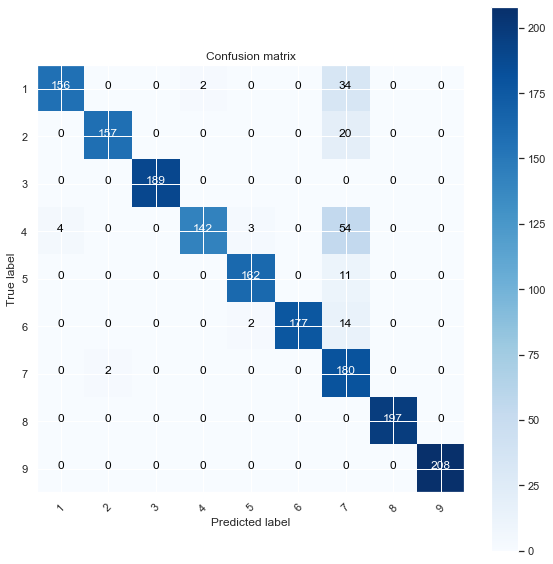

In [102]:
classes=[1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(y_test,test_pre), classes,
                          normalize=False,
                          title='Confusion matrix'
                         )
plt.show()

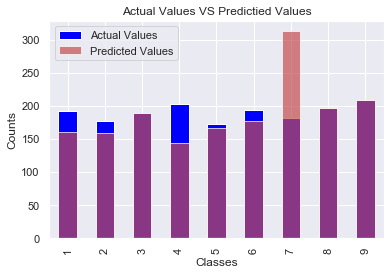

In [104]:
# Prediction vs Actual Values
y_test.value_counts().sort_index().plot(kind='bar',label='Actual Values',color='blue')
pd.Series(test_pre).value_counts().sort_index().plot(kind='bar',label='Predicted Values',color='r',alpha=0.7)
plt.title('Actual Values VS Predictied Values')
plt.xlabel('Classes')
plt.ylabel("Counts")
plt.legend()
plt.show()